In [1]:
# Rodrigo Caye Daudt
# rodrigo.cayedaudt@geod.baug.ethz.ch
# 02/2021

from skimage import io
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import io as sio

import rpc
import cross_correlation

%load_ext autoreload
%autoreload 2

In [2]:
# General parameters

# Choose which scene will be analysed
SCENE_NUMBER = 2 # 1 or 2

FORCE_RECOMPUTE = False # If True, ignores saved .npz files

# Define parameters
template_radius = 7 # 3 or 7 for a window of size 7 or 15
stride = 5 # 25 or 50 for testing code, 5 for generating final results
search_window_radius = 10 + template_radius # don't change this

In [3]:
# Load data

# Load images
img1 = io.imread('data/pan000_wal8_scene{}.tif'.format(str(SCENE_NUMBER)))
img2 = io.imread('data/pan001_wal8_scene{}.tif'.format(str(SCENE_NUMBER)))

# Load affine transform
mat = sio.loadmat('data/Aff.mat')
aff1 = mat['Aff1']
aff2 = mat['Aff2']

# Load RPCs
mat = sio.loadmat('data/rpcs.mat')
coeff1 = mat['coeff1']
I1 = mat['I1']
O1 = mat['O1']
coeff2 = mat['coeff2']
I2 = mat['I2']
O2 = mat['O2']

# Load approximate position values
# Explanation: pixel [i,j] in image 1 can be found approximately in location [approxY[i,j],approxX[i,j]] in image 2
mat = sio.loadmat('data/approx_scene{}.mat'.format(str(SCENE_NUMBER)))
approxX = mat['approxX']
approxY = mat['approxY']
del(mat)

# Create output folder
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [4]:
approxX.shape, approxY.shape, img1.shape

((2300, 2000), (2300, 2000), (2300, 2000))

In [5]:
h1 = np.array([[1, 2], [2, 3]])
h2 = np.array([[2, 4], [1, 6]])
m1 = np.mean(h1, axis=None)
h1 * h2

array([[ 2,  8],
       [ 2, 18]])

In [6]:
m1

2.0

In [7]:
np.linalg.norm(cross_correlation.normalize(h1)), cross_correlation.normalize(h1)

(1.0,
 array([[-0.5, -0.5],
        [ 0.5,  0.5]]))

In [8]:
h1, np.mean(h1, axis=1)

(array([[1, 2],
        [2, 3]]),
 array([1.5, 2.5]))

In [9]:
# Main normalized cross correlation loop - results are saved the first time and loaded by default for convenience
# IMPORTANT NOTE: axis 0 is Y and axis 1 is X

force_points_recompute = False
FORCE_RECOMPUTE = False
if FORCE_RECOMPUTE or not os.path.exists(f'outputs/matches_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}_stride_{stride}.npz'):
    force_points_recompute = True 

    # Initialize variables to store coordinates X and Y in images 1 and 2, as well as normalized cross correlation
    matched_points_x_img1 = []
    matched_points_y_img1 = []
    matched_points_x_img2 = []
    matched_points_y_img2 = []
    matched_points_ncc = []

    # Initialize varialbes for visualizing ncc and displacement
    ncc_vis = -np.ones((len(range(0, img1.shape[0], stride)), len(range(0, img1.shape[1], stride))))
    displacement_vis = -np.ones((len(range(0, img1.shape[0], stride)), len(range(0, img1.shape[1], stride))))

    # Main loop
    for i_vis,i in enumerate(tqdm(range(template_radius, img1.shape[0] - template_radius, stride))):
        for j_vis,j in enumerate(range(template_radius, img1.shape[1] - template_radius, stride)):

            # Cut template image from img1 
            template = img1[i - template_radius : i + template_radius + 1, j - template_radius: j + template_radius + 1]

            # Find approximate target location and cut search area from img2
            # Make sure cut window fall inside image boundaries
            y_c = approxY[i, j] + i # window center using i and approxY
            y0 = y_c - search_window_radius
            y1 = y_c + search_window_radius + 1
            x_c = approxX[i, j] + j # window center using j and approxX
            x0 = x_c - search_window_radius
            x1 = x_c + search_window_radius + 1
            assert img2.shape[0] > y1 > y0 > 0 and img2.shape[1] > x1 > x0 > 0 
            search_area = img2[y0:y1, x0:x1]
            
            # Assert search_area is bigger than template (size could be squished around boundaries)
            x_check = search_area.shape[1] > template_radius * 2 + 1
            y_check = search_area.shape[0] > template_radius * 2 + 1
            if not x_check or not y_check:
                print(f'Warning: search area size too small in pixel ({i}, {j}). Skipping...')
                continue

            # Call cross_correlation, you need to fill in this function
            dx, dy, ncc = cross_correlation.cross_correlation(template, search_area)

#             print(dx, dy, ncc)
            # Save lists with information about matched points
            # Be very careful to consider all the offsets to store coordinates
            matched_points_x_img1.append(j)
            matched_points_y_img1.append(i)
            matched_points_x_img2.append(dx + x0)
            matched_points_y_img2.append(dy + y0)
            matched_points_ncc.append(ncc)


            # Mark matched points
            ncc_vis[i_vis,j_vis] = ncc
            displacement_vis[i_vis,j_vis] = np.linalg.norm([matched_points_x_img2[-1] - matched_points_x_img1[-1], matched_points_y_img2[-1] - matched_points_y_img1[-1]])

    # Save results
    np.savez(f'outputs/matches_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}.npz', matched_points_x_img1, matched_points_y_img1, matched_points_x_img2, matched_points_y_img2, matched_points_ncc, ncc_vis, displacement_vis)

else:
    # Load results if they already exist
    print('Loading previous results...')
    npzfile = np.load(f'outputs/matches_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}_stride_{stride}.npz')
    matched_points_x_img1 = npzfile['arr_0']
    matched_points_y_img1 = npzfile['arr_1']
    matched_points_x_img2 = npzfile['arr_2']
    matched_points_y_img2 = npzfile['arr_3']
    matched_points_ncc = npzfile['arr_4']
    ncc_vis = npzfile['arr_5']
    displacement_vis = npzfile['arr_6']
   

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 270/458 [1:08:38<47:47, 15.25s/it]


KeyboardInterrupt: 

In [11]:
(f'outputs/matches_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}.npz', matched_points_x_img1, matched_points_y_img1, matched_points_x_img2, matched_points_y_img2, matched_points_ncc, ncc_vis, displacement_vis)


('outputs/matches_scene_2_15x15.npz',
 [7,
  12,
  17,
  22,
  27,
  32,
  37,
  42,
  47,
  52,
  57,
  62,
  67,
  72,
  77,
  82,
  87,
  92,
  97,
  102,
  107,
  112,
  117,
  122,
  127,
  132,
  137,
  142,
  147,
  152,
  157,
  162,
  167,
  172,
  177,
  182,
  187,
  192,
  197,
  202,
  207,
  212,
  217,
  222,
  227,
  232,
  237,
  242,
  247,
  252,
  257,
  262,
  267,
  272,
  277,
  282,
  287,
  292,
  297,
  302,
  307,
  312,
  317,
  322,
  327,
  332,
  337,
  342,
  347,
  352,
  357,
  362,
  367,
  372,
  377,
  382,
  387,
  392,
  397,
  402,
  407,
  412,
  417,
  422,
  427,
  432,
  437,
  442,
  447,
  452,
  457,
  462,
  467,
  472,
  477,
  482,
  487,
  492,
  497,
  502,
  507,
  512,
  517,
  522,
  527,
  532,
  537,
  542,
  547,
  552,
  557,
  562,
  567,
  572,
  577,
  582,
  587,
  592,
  597,
  602,
  607,
  612,
  617,
  622,
  627,
  632,
  637,
  642,
  647,
  652,
  657,
  662,
  667,
  672,
  677,
  682,
  687,
  692,
  697,
  702,
  

In [ ]:
matched_points_y_img1[-5: ], matched_points_y_img2[-5: ]
# np.min(approxY), np.max(approxY), np.min(approxX), np.max(approxX)
# approxX[:5], approxY[:5]
np.mean(matched_points_ncc)

In [ ]:
np.array(matched_points_x_img1) - np.array(matched_points_x_img2)
np.array(matched_points_y_img1) - np.array(matched_points_y_img2)
# np.min(ncc_vis), np.max(ncc_vis)

In [ ]:
# Plot and save

# NCC
ncc_vis2 = ncc_vis.copy()
ncc_vis2[ncc_vis < 0.6] = 0
fig = plt.figure()
io.imshow(ncc_vis2, cmap='jet')
plt.title('Normalized cross correlation')
io.imsave(f'outputs/scene_{SCENE_NUMBER}-01-ncc_{2*template_radius+1}x{2*template_radius+1}.png', 0.5 + 0.5 * ncc_vis)
plt.savefig(f'outputs/scene_{SCENE_NUMBER}-01-ncc_{2*template_radius+1}x{2*template_radius+1}.pdf')

# Displacement
# the vector difference between the matched point in img1 and img2
plt.figure()
plt.title('Displacement')
io.imshow(displacement_vis, cmap='jet')
io.imsave(f'outputs/scene_{SCENE_NUMBER}-02-displacement_{2*template_radius+1}x{2*template_radius+1}.png', displacement_vis / displacement_vis.max())
plt.savefig(f'outputs/scene_{SCENE_NUMBER}-02-displacement_{2*template_radius+1}x{2*template_radius+1}.pdf')

In [ ]:
np.min(ncc_vis2), np.max(ncc_vis2)

In [ ]:
# Forward intersection

if FORCE_RECOMPUTE or force_points_recompute or not os.path.exists(f'outputs/points_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}.npz'):

    # Offsets that were used to crop images 1 and 2 for scenes 1 and 2
    if SCENE_NUMBER == 1:
        cut_image1 = np.array([6900, 11000, 0])
        cut_image2 = cut_image1 + [-50, -200, 0]
    elif SCENE_NUMBER == 2:
        cut_image1 = np.array([800, 14200, 0])
        cut_image2 = cut_image1 + [-150, -100, 0]
    else:
        print('Scene number must be 1 or 2.')
        raise Exception

    # Initial value for iterative search in forward intersection. Don't change this value, it works for all points.
    X0 = np.array([46.0, 7.0, 650.0, 1.0])

    X = np.zeros((4,0))
    for i in tqdm(range(len(matched_points_ncc))):
        if matched_points_ncc[i] >= 0.6:
            # Define point coordinates in image 1 and image 2 (considering cut offset)
            x1 = [matched_points_x_img1[i], matched_points_y_img1[i], 1] + cut_image1
            x2 = [matched_points_x_img2[i], matched_points_y_img2[i], 1] + cut_image2

            # Affine RPC refinement
            xc1 = np.matmul(np.linalg.pinv(aff1), x1)
            xc2 = np.matmul(np.linalg.pinv(aff2), x2)
            
            # Forward intersection 
            X_new = rpc.rpc_inv(X0.copy(),xc1,xc2,coeff1,I1,O1,coeff2,I2,O2)
            
            
            # Store result
            X = np.concatenate((X,X_new), axis=1)

    # Convert points back to UTM 32 N    
    Xn, utm_zones = rpc.deg2utm(X)


    print('Saving points...')
    np.savez(f'outputs/points_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}.npz', Xn, utm_zones)
    print('\nSaved. Use visaluse_points.py to plot points.')
else:
    print('Loading previous points...')
    X = np.load(f'outputs/points_scene_{SCENE_NUMBER}_{2*template_radius+1}x{2*template_radius+1}.npz')['arr_0']

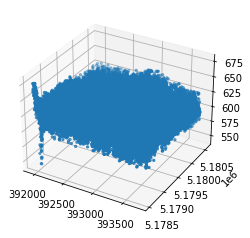

In [44]:
# visualize matches

from mpl_toolkits.mplot3d import Axes3D

RADIUS = template_radius

if not os.path.exists(f'outputs/points_scene_{SCENE_NUMBER}_{2*RADIUS+1}x{2*RADIUS+1}.npz'):
    print('\n\nPoints must me precomputed.\n\n')
    raise Exception

X = np.load(f'outputs/points_scene_{SCENE_NUMBER}_{2*RADIUS+1}x{2*RADIUS+1}.npz')['arr_0']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0,:], X[1,:], X[2,:], marker='.')
plt.show()

In [62]:
Xn.shape

(4, 4161)